# Scraping board game data from boardgamegeek.com

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time
import urllib
import xml.etree.ElementTree as etree
from bs4 import BeautifulSoup
from urllib.request import urlopen

## Initial scrape of data

Set up make_soup definition

In [1]:
def make_soup(url):
    html = urlopen(url).read()
    return BeautifulSoup(html, "lxml")

Set up lists to fill and base url

In [7]:
ranks = []
titles = []
game_urls = []
geek_ratings = []
avg_ratings = []
num_voters = []
game_id = []

In [3]:
base_url = 'http://boardgamegeek.com'

In [9]:
for pg in range(1, 151): # max is 819, but games with reliable ratings (ones with enough voters) end at page 150 with game 14907, max range is 151
    soup = make_soup(base_url + '/browse/boardgame/page/' + str(pg))
    table = soup.find('table', {'class' : 'collection_table'})

    for row in table.findAll('tr', {'id' : 'row_'}):
        col = row.findAll('td')
    
        rank = int(col[0].get_text())
        ranks.append(rank)

        title = col[2].find('a').get_text()
        titles.append(title)
    
        url = col[2].find('a').get('href')
        game_urls.append(url)
    
        bgg = float(col[3].get_text())
        geek_ratings.append(bgg)
    
        avg = float(col[4].get_text())
        avg_ratings.append(avg)
    
        num = float(col[5].get_text())
        num_voters.append(num)

ValueError: invalid literal for int() with base 10: '\n\t\t\t\t\t\tN/A\t\t\t\n\t\t\t\t\t'

Collect scraped data into dataframe

In [9]:
data = {'Rank' : ranks, 'Game Titles' : titles, 'Geek Rating' : geek_ratings, 
                'Avg. Rating' : avg_ratings,'# Voters' : num_voters, 'Game url' : game_urls}
                
data_df = pd.DataFrame(data)

Will I be able to use all the data? Or should I sort by something before moving on to requesting more game data from the API?
Maybe sort by number of voters and set some threshold?

In [59]:
data_df = pd.read_csv('data_df.csv', sep=',', encoding='latin-1')
data_df.head()

,Unnamed: 0,# Voters,Avg. Rating,Game Titles,Game Url,Geek Rating,Rank
0,0,9345,9.02,Gloomhaven,/boardgame/174430/gloomhaven,8.509,1
1,1,23138,8.66,Pandemic Legacy: Season 1,/boardgame/161936/pandemic-legacy-season-1,8.498,2
2,2,10491,8.66,Through the Ages: A New Story of Civilization,/boardgame/182028/through-ages-new-story-civil...,8.325,3
3,3,29757,8.35,Twilight Struggle,/boardgame/12333/twilight-struggle,8.211,4
4,4,19840,8.38,Terraforming Mars,/boardgame/167791/terraforming-mars,8.172,5


In [60]:
data_df_sortbyvoters = data_df.sort_values(by=['# Voters'], ascending=False)

In [61]:
data_df_sortbyvoters.head()

,Unnamed: 0,# Voters,Avg. Rating,Game Titles,Game Url,Geek Rating,Rank
270,270,73842,7.24,Catan,/boardgame/13/catan,7.091,271
135,135,73509,7.43,Carcassonne,/boardgame/822/carcassonne,7.331,136
64,64,70018,7.66,Pandemic,/boardgame/30549/pandemic,7.571,65
60,60,60553,7.68,Dominion,/boardgame/36218/dominion,7.582,61
39,39,57965,7.81,7 Wonders,/boardgame/68448/7-wonders,7.726,40


In [11]:
len(data_df_sortbyvoters[data_df_sortbyvoters['# Voters']>100])

8025

In [13]:
data_df_red = data_df_sortbyvoters[data_df_sortbyvoters['# Voters']>1000]
data_df_red['Avg. Rating'].max(), data_df_red['Avg. Rating'].min()

(9.0700000000000003, 2.1899999999999999)

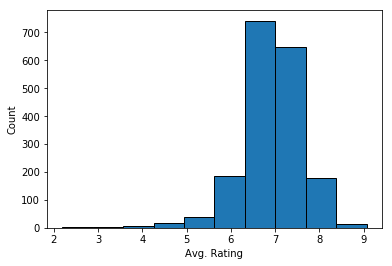

In [20]:
y_Avg = data_df_red['Avg. Rating']
plt.hist(y_Avg, edgecolor='black')
plt.xlabel('Avg. Rating')
plt.ylabel('Count')
axes = plt.gca()
plt.show()

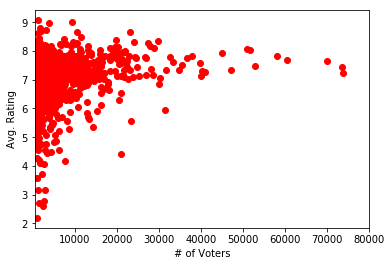

In [21]:
x_voters = data_df_red['# Voters']
plt.plot(x_voters, y_Avg, 'ro')
plt.xlabel('# of Voters')
plt.ylabel('Avg. Rating')
axes = plt.gca()
axes.set_xlim([500, 80000])
plt.show()

## Extract game IDs from game URLs

In [62]:
game_id_sortbyvoters = [row.split('game/')[1].split('/')[0] for row in data_df['Game Url']]

In [63]:
print(len(game_id_sortbyvoters))

14907


In [64]:
data_df['game id'] = [row.split('game/')[1].split('/')[0] for row in data_df['Game Url']]

In [32]:
data_df = data_df.set_index('game id')

In [65]:
data_df.head()

,Unnamed: 0,# Voters,Avg. Rating,Game Titles,Game Url,Geek Rating,Rank,game id
0,0,9345,9.02,Gloomhaven,/boardgame/174430/gloomhaven,8.509,1,174430
1,1,23138,8.66,Pandemic Legacy: Season 1,/boardgame/161936/pandemic-legacy-season-1,8.498,2,161936
2,2,10491,8.66,Through the Ages: A New Story of Civilization,/boardgame/182028/through-ages-new-story-civil...,8.325,3,182028
3,3,29757,8.35,Twilight Struggle,/boardgame/12333/twilight-struggle,8.211,4,12333
4,4,19840,8.38,Terraforming Mars,/boardgame/167791/terraforming-mars,8.172,5,167791


In [78]:
print(len(np.unique(data_df['game id'])))

14907


In [19]:
#type(game_id_sortbyvoters[0])
pg=str(822)
int(data_df.loc[pg]['# Voters']/100)+1

736

In [79]:
print(game_id_sortbyvoters[:11])

['174430', '161936', '182028', '12333', '167791', '187645', '120677', '169786', '173346', '84876', '193738']


## Obtain data on game categories/mechanics and user ratings from the API

In [71]:
base = "http://www.boardgamegeek.com/xmlapi2/"
api1 = "thing?id="
api2 = "&stats=1"
api3 = '&ratingcomments=1&pagesize=100'
api4 = '&page='

Initialize lists

In [81]:
game = []
var = []
value = []
gameName = []
description = []
userName = []
userRating = []
userComment = []
userInfo = []
yearPub = []
usersRated = []
owned = []
tradingmkt = []
wanting = []
wishing = []
numComments = []
avgWeight = []
playTime = []
minPlayers = []
maxPlayers = []
minAge = []
thumbnail = []

In [42]:
gameName = []
userInfo = []

Setting up API request-done in delayed batches due to throttling

In [82]:
floor = 0
ceiling = 10

In [83]:
for iteration in range(0,746):
    print(iteration)
    for pg in game_id_sortbyvoters[floor:ceiling]:
        print(pg)
        url = base + api1 + str(pg) + api2  + api3 + api4
        response = urlopen(url)
        
        ### parse XML
        tree = etree.parse(response)
        root = (tree.getroot())[0] ### actually sets single child of root as root

        ### retrieve data from XML file
        linklist = root.findall("link") ### this contains category/mechanic, etc.

        for node in range(0, len(linklist)):
            game.append(root.find("name").get("value"))

        ### get variable name (e.g., mechanic, category, etc.) and value
        for node in linklist:
            var.append(node.get("type"))
            value.append(node.get("value")) 
            
        gameName.append(root.find("name").get("value"))
        yearPub.append(root.find('yearpublished').get('value'))
        playTime.append(root.find('playingtime').get('value'))
        minPlayers.append(root.find('minplayers').get('value'))
        maxPlayers.append(root.find('maxplayers').get('value'))
        minAge.append(root.find('minage').get('value'))
        thumbnail.append(root.find('image').text)
        description.append(root.find('description').text)
        
        time.sleep(2)
        
        for pginc in range(1, int(data_df_red.loc[pg]['# Voters']/100)+1):
        #    print(pginc)
            url = base + api1 + str(pg) + api2 + api3 + api4 + str(pginc)
            response = urlopen(url)

           ### parse XML
            tree = etree.parse(response)
            root = (tree.getroot())[0] ### actually sets single child of root as root        

            gameName.append(root.find("name").get("value"))
            
            for node in root.iter('comment'): ## creates dictionary of username, rating, comment (if it exists)
                userInfo.append(node.attrib)

            for item in userInfo:
                item.update({'game':gameName[0]})
            
            userInfo[0]['game'] = gameName[0]
            userName.append([x['username'] for x in userInfo])
            userRating.append([x['rating'] for x in userInfo])
            userComment.append([x['value']for x in userInfo])
    
            time.sleep(1)
        
    time.sleep(2)
    floor = floor + 10
    ceiling = ceiling + 10       

403
191364
9143
24209
180006
232139
705
217547
172088
14553
8727
121076
5275
38836
6417
187700
84671
97521
150220
19651
20120
404
121076
5275
38836
6417
187700
84671
97521
150220
19651
20120
158586
12900
27830
230785
134419
194640
167190
127989
23550
204601
405
158586
12900
27830
230785
134419
194640
167190
127989
23550
204601
19253
3825
172278
191895
178051
17208
226354
194301
20587
145344
406
19253
3825
172278
191895
178051
17208
226354
194301
20587
145344
6405
8356
9866
85004
9577
3998
24079
9509
7834
141467
407
6405
8356
9866
85004
9577
3998
24079
9509
7834
141467
212687
4252
215392
100447
3691
184797
193291
219638
6381
20675
408
212687
4252
215392
100447
3691
184797
193291
219638
6381
20675
96440
197911
63868
3616
69105
4294
230667
3229
5900
1071
409
96440
197911
63868
3616
69105
4294
230667
3229
5900
1071
5200
209001
148074
110245
7640
226860
130004
4107
3471
121715
410
5200
209001
148074
110245
7640
226860
130004
4107
3471
121715
133620
42591
2567
40005
95679
223454
171579
3806


21269
70096
1687
708
150827
34245
66695
153002
5692
178154
97248
74678
469
1687
708
150827
34245
66695
153002
5692
178154
97248
74678
4176
7980
5930
10267
21061
1003
209567
4336
7578
120509
470
4176
7980
5930
10267
21061
1003
209567
4336
7578
120509
17146
10822
4967
225981
6653
158059
84776
144587
137912
146747
471
17146
10822
4967
225981
6653
158059
84776
144587
137912
146747
10998
209282
87876
3022
55841
164279
14010
209542
117975
162660
472
10998
209282
87876
3022
55841
164279
14010
209542
117975
162660
95449
23605
47414
112445
208543
230275
23999
29106
135107
121995
473
95449
23605
47414
112445
208543
230275
23999
29106
135107
121995
64769
11135
1043
28553


AttributeError: 'NoneType' object has no attribute 'text'

In [102]:
d = {'game': gameName, 'yearPub': yearPub, 'playTime': playTime, 'minPlayers': minPlayers, 'maxPlayers': maxPlayers, 'minAge': minAge, 'thumbnail': thumbnail, 'description': description}
df = pd.DataFrame(data=d)

In [103]:
df.head()

,description,game,maxPlayers,minAge,minPlayers,playTime,thumbnail,yearPub
0,Relive the entire Cold War in ten minutes with...,Twilight Squabble,2,14,2,15,https://cf.geekdo-images.com/images/pic2908587...,2016
1,(from the back of the box:)&#10;&#10;War in Eu...,War in Europe (second edition),3,12,1,360,https://cf.geekdo-images.com/images/pic301195.jpg,1999
2,Kaleidos Junior comes with four identical sets...,Kaleidos Junior,99,5,2,30,https://cf.geekdo-images.com/images/pic1985224...,1997
3,This game looks a simple trick-taking game. Ea...,Fram R'lyeh,5,12,3,20,https://cf.geekdo-images.com/images/pic2575665...,2015
4,"Autumn For Barbarossa, (AfB) is a Standard Com...",Autumn For Barbarossa,2,180,2,0,https://cf.geekdo-images.com/images/pic3692332...,2017


In [104]:
df.to_csv('FullGameStats2.csv')

In [44]:
Game_Ratings = pd.DataFrame(userInfo)

In [46]:
Game_Ratings.head()
#print(len(Game_Ratings))

,game,rating,username,value
0,Ticket to Ride: Europe,10,tracy333,
1,Ticket to Ride: Europe,10,Mrgoodfella,
2,Ticket to Ride: Europe,10,qulboj,
3,Ticket to Ride: Europe,10,Jardermorder,
4,Ticket to Ride: Europe,10,Pinkpaw,


In [47]:
Game_Ratings.to_csv('Game_Ratings_part2')

In [144]:
Game_stats = pd.DataFrame({'Game':gameName, 'YearPub': yearPub, 'Min_Players': minPlayers, 'Max_players': maxPlayers, 'Play Time': playTime, 'Min Age': minAge, 'Thumbnail': thumbnail})

In [145]:
Game_stats.head()

,Game,Max_players,Min Age,Min_Players,Play Time,Thumbnail,YearPub
0,Catan,4,10,3,120,https://cf.geekdo-images.com/images/pic2419375...,1995
1,Carcassonne,5,8,2,45,https://cf.geekdo-images.com/images/pic2337577...,2000
2,Pandemic,4,8,2,45,https://cf.geekdo-images.com/images/pic1534148...,2008
3,Dominion,4,13,2,30,https://cf.geekdo-images.com/images/pic394356.jpg,2008
4,7 Wonders,7,10,2,30,https://cf.geekdo-images.com/images/pic860217.jpg,2010


In [147]:
multiData = pd.DataFrame({'Game' : game, 'Variable' : var, 'Value' : value})

In [148]:
multiData.head()

,Game,Value,Variable
0,Catan,Negotiation,boardgamecategory
1,Catan,Dice Rolling,boardgamemechanic
2,Catan,Hand Management,boardgamemechanic
3,Catan,Modular Board,boardgamemechanic
4,Catan,Route/Network Building,boardgamemechanic


In [48]:
print(gameName[0:10])

['Ticket to Ride: Europe', 'Codenames', 'Race for the Galaxy', 'Splendor', 'Dixit', 'Stone Age']


In [146]:
Game_stats.to_csv('Game_stats')

In [65]:
#Carcassone_userdata = pd.DataFrame(userInfo)
Carcassone_userdata.tail()
y = Carcassone_userdata['rating']
#print(np.unique(y))
#plt.hist(y, bins=[2,3,4,5,6,7,8,9,10])
#plt.xlabel('User Rating')
#plt.ylabel('Count')
#axes = plt.gca()
#plt.show()
#Carcassone_userdata.to_csv('CarcassoneUserData')

In [92]:
print(len(userInfo))

73800


# Data preprocessing

In [3]:
Full_game_data = pd.read_csv('FullData.csv', sep=',')

In [4]:
Full_game_data.head()

,Unnamed: 0,Avg Rating,Avg Weight,Bayes Rating,Game,Median Rating,Num Comments,Num Weights,Overall Ranking,Owned,...,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,0,8.66813,2.7955,8.49327,Pandemic Legacy: Season 1,0,3438,670,1,33677,...,0,0,0,0,0,0,0,0,0,0
1,1,8.69076,4.3348,8.32563,Through the Ages: A New Story of Civilization,0,1366,460,2,12152,...,0,0,0,0,0,0,0,0,0,0
2,2,8.35524,3.5385,8.21500,Twilight Struggle,0,6792,2986,3,39390,...,0,0,0,0,0,1,0,0,0,0
3,3,8.99507,3.7466,8.18108,Gloomhaven,0,1593,296,4,7879,...,0,0,0,0,0,0,0,0,0,0
4,4,8.50861,3.5698,8.16017,Star Wars: Rebellion,0,1753,351,5,16557,...,0,0,0,0,0,1,0,0,0,0


In [9]:
Full_game_data.groupby('Year Published')['Game'].count()

In [5]:
drop_list = ['Unnamed: 0', 'Game', 'Bayes Rating', 'Avg Rating', 'Avg Weight', 'Median Rating', 'Num Comments', 'Num Weights', 'Overall Ranking', 'Owned', 'StdDev Rating', 'Trading', 'Users Rated', 'Wanting', 'Wishing', 'Year Published']

In [6]:
Full_features = Full_game_data.drop(drop_list, axis=1) ## df now contains all of the boolean features for each game
Full_features.head()

,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,...,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
features = Full_features.columns.values.tolist()
print(features)

['Acting', 'Action / Movement Programming', 'Action Point Allowance System', 'Area Control / Area Influence', 'Area Enclosure', 'Area Movement', 'Area-Impulse', 'Auction/Bidding', 'Betting/Wagering', 'Campaign / Battle Card Driven', 'Card Drafting', 'Chit-Pull System', 'Co-operative Play', 'Commodity Speculation', 'Crayon Rail System', 'Deck / Pool Building', 'Dice Rolling', 'Grid Movement', 'Hand Management', 'Hex-and-Counter', 'Line Drawing', 'Memory', 'Modular Board', 'Paper-and-Pencil', 'Partnerships', 'Pattern Building', 'Pattern Recognition', 'Pick-up and Deliver', 'Player Elimination', 'Point to Point Movement', 'Press Your Luck', 'Rock-Paper-Scissors', 'Role Playing', 'Roll / Spin and Move', 'Route/Network Building', 'Secret Unit Deployment', 'Set Collection', 'Simulation', 'Simultaneous Action Selection', 'Singing', 'Stock Holding', 'Storytelling', 'Take That', 'Tile Placement', 'Time Track', 'Trick-taking', 'Variable Phase Order', 'Variable Player Powers', 'Voting', 'Worker P

In [88]:
test = Full_features.values

In [9]:
sns.set(style='white')

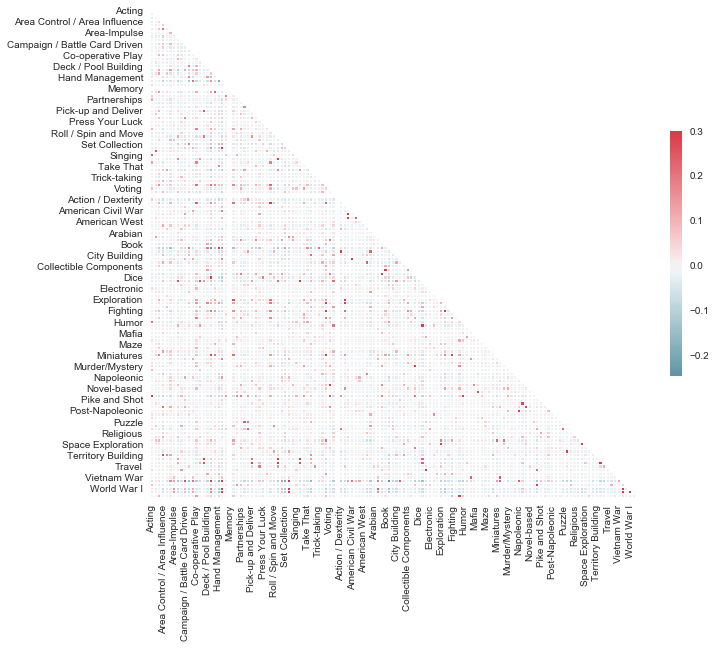

In [14]:
corr = Full_features.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('featurecorr.png', bbox_inches='tight')
plt.show()

In [12]:
#plt.show()
plt.savefig('featurecorr.png', bbox_inches='tight')

In [68]:
userpool = pd.read_csv('CatanUserData_part2', sep=',', encoding='latin1')

In [69]:
userpool.head()

,Unnamed: 0,game,rating,username,value
0,0,Catan,10.0,Mrgoodfella,NaN
1,1,Catan,10.0,codytrotter,NaN
2,2,Catan,10.0,StevenTM,NaN
3,3,Catan,10.0,Freddywolf75,NaN
4,4,Catan,10.0,Lewiscarroll2,NaN


In [70]:
userpool.drop(['Unnamed: 0', 'value'], axis=1, inplace=True)
userpool.head()

,game,rating,username
0,Catan,10.0,Mrgoodfella
1,Catan,10.0,codytrotter
2,Catan,10.0,StevenTM
3,Catan,10.0,Freddywolf75
4,Catan,10.0,Lewiscarroll2


In [48]:
print(len(userpool))

73800


## Reducing user pool

In [49]:
import random

In [107]:
userpool_red = userpool.iloc[np.random.choice(userpool.index, 2200, replace=False)]

For some reason, the API request gives an error if the username has a space in it. I think this is becauses a '%20' needs to be added in place of spaces in order to give a working URL. So I've just removed usernames that have spaces for now. 

In [110]:
testcount = userpool_red['username'].str.contains(' ').sum()
print(testcount)

0


In [109]:
userpool_red = userpool_red[userpool_red.username.str.contains(' ') == False]

In [111]:
userpool_red.head()

,game,rating,username
69223,Catan,5.0,NotFakeSteveJobs
72066,Catan,4.0,StarZanite
29473,Catan,8.0,Silverback
42013,Catan,7.0,codester56
71331,Catan,4.5,Huntright


In [112]:
print(len(userpool_red))

2125


Choosing a pool of ~2000 random users from the pool of people who have rated Catan - need to note this as a possible bias

In [113]:
userpool_red.groupby('username').nunique().count()

game        2125
rating      2125
username    2125
dtype: int64

This confirms that the ~2000 usernames are unique

In [114]:
userpool_red.to_csv('userpool_red')

In [115]:
userpool_red['username'][:20]

69223    NotFakeSteveJobs
72066          StarZanite
29473          Silverback
42013          codester56
71331           Huntright
42304             h2mommy
60399           slewis127
47945           saintjimb
55794              Xaqery
53057               Jenny
1408           pcanalejas
8790             joe_monk
35713        thejasonhall
46865           characith
42256             joeplus
58102               HSuke
17217              Sumzor
59095                Dryk
37462                zold
46266         BoshJeeples
Name: username, dtype: object

In [150]:
print(np.unique(user_name))

['Alfenakenleaf' 'BadMuzzy' 'BoshJeeples' 'Ciuniek' 'Danisme' 'Derrick'
 'Dryk' 'HSuke' 'Hoop27' 'Huntright' 'Informal_Geek' 'Jenny' 'Jens4029'
 'LiddellE' 'Milamber8' 'MonkeyDLuffy' 'Naturelich' 'NotFakeSteveJobs'
 'Omar_Bang' 'PaintVagrant' 'Ranchfester' 'RckmRobot' 'RickJosh'
 'Schreinereiner' 'Silverback' 'Sparklie' 'StarZanite' 'Sumzor' 'TheHouse'
 'Tigerherz' 'Warpspawngames' 'Xaqery' 'ajevans' 'amiller0206'
 'batbatterton' 'characith' 'cirdan' 'codester56' 'csb0xc4rs'
 'dianacronica' 'dztheflea' 'eddyspaghetti' 'emanuelcb' 'emma_88' 'h2mommy'
 'halobungieman' 'joe_monk' 'joeplus' 'kalungplus6' 'kittenrainbow'
 'lucasaresende' 'magoula' 'melachrinos' 'melchett' 'paploo' 'pcanalejas'
 'ray3127' 's3rvant' 'saintjimb' 'schoebta' 'sembo' 'slewis127'
 'thejasonhall' 'tima' 'vitus979' 'zold']


In [153]:
userpool_red = userpool_red[userpool_red.username.isin(user_name) == False]

In [154]:
print(len(userpool_red))

2059


In [158]:
print(userpool_red['username'][:20])

19851            Quantiarc
10735             alicat27
57537       SuzyPlantation
39034          Miss_Meeple
35296           fanofwalls
43353             BiNiaRiS
56076                 hjo3
66233            vigornian
17354    makesh1ft_m1l1t1a
54500        andrewgoodwyn
46081           wizardoest
53121                Sicia
34940             Ouwekaas
25030           separatrix
31679      Raving_Engineer
31629        stwerner92182
49091      Fist_fulla_zotz
30808             mtngrown
50755             Neurobry
1238              AkashMan
Name: username, dtype: object


In [14]:
def check_url(url, num_tries, wait_secs):
    ##Check whether a url is valid. Allows multiple checks with waiting in between."""
    import time
    import urllib
    for x in range(0, num_tries):  
        try:
            conn = urlopen(url)
            #code = a.getcode()
            #str_error = None
        except urllib.error.HTTPError as str_error:
        #    pass
            print('HTTPError')
            time.sleep(wait_secs)
        except urllib.error.URLError as str_error:
        #if str_error:
            print('URLError')
            time.sleep(wait_secs)  
        else:
            str_error=None
            break
    return str_error

In [15]:
check_url('https://www.boardgamegeek.com/xmlapi2/collection?username=Chris%20McKerron&stats=1&rated=1', 4, 60)

# Obtain data on user ratings from API

In [174]:
import urllib
base = "http://www.boardgamegeek.com/xmlapi2/"
api1 = "collections?username="
api2 = "&stats=1"
api3 = '&rated=1'
api4 = '&excludesubtype=boardgameexpansion'

gameid = []
game_name = []
rating = []
#userpoolInfo = []
user_name = []
i=1

floor = 0
ceiling = 20

for iteration in range(0, 104): #104
    print(iteration)
    for user in userpool_red['username'][floor:ceiling]:
        print(i)
        #print(user)
        url = base + api1 + str(user) + api2 + api3 + api4

        #num_tries = 5
        #wait_secs = 5
        #check_url(url, num_tries, wait_secs)

        #for x in range(0, num_tries):
        try:
            response = urlopen(url)
        except urllib.error.HTTPError:
            print('HTTP Error')
            #time.sleep(wait_secs)
            continue

        #response = urlopen(url)

        ### parse XML
        tree = etree.parse(response)
        root = tree.getroot() ### actually sets single child of root as root

        for child in root:
            gameid.append(child.attrib['objectid'])
            game_name.append(child.find('name').text)
            rating.append(child.find('stats').find('rating').get('value'))
            user_name.append(user)
            #childdata = {'username' : user_name, 'game id' : gameid, 'Game' : game_name, 'Rating' : rating}
        print(user)
        #userpoolInfo.append(childdata)
        #for item in userpoolInfo:
        #    item.update({'username': user})
        #print(userpoolInfo)
        time.sleep(1)
        i+=1
        
    time.sleep(5)
    floor = floor + 20
    ceiling = ceiling + 20

0
1
Quantiarc
2
alicat27
3
SuzyPlantation
4
Miss_Meeple
5
fanofwalls
6
BiNiaRiS
7
hjo3
8
vigornian
9
makesh1ft_m1l1t1a
10
andrewgoodwyn
11
wizardoest
12
Sicia
13
Ouwekaas
14
separatrix
15
Raving_Engineer
16
stwerner92182
17
Fist_fulla_zotz
18
mtngrown
19
Neurobry
20
AkashMan
1
21
richardtock
22
kvnmcfddn
23
jutapo
24
elralfo
25
voynitsky
26
Kangaroodle
27
Greenm4n
28
Baethan
29
Xerlot
30
vodu
31
iPainter
32
pbostrom
33
aniaw89
34
Stircrazy
35
kozono
36
Erolyn
37
gamesforbreakfast
38
Shi_no_Kami
39
willbnz
40
JuggleGod
2
41
futureofrock
42
st_ginger
43
lizwilliams
44
Neville17
45
60APES
46
Angeron
47
frnknstn
48
Blake7
49
dexploratio
50
wh0ney
51
liquidus69
52
Xcalibershard
53
Segismundo
54
Eykhon
55
pancho_kk
56
matt769
57
milhowse
58
piscine
59
alhails2
60
Stephyk923
3
61
ZePawnFuhrer
62
nedds9
63
Bloater
64
Erik999
65
jaredgrubb
66
Bszzsolt
67
santamuri
68
Bigdanorama
69
kvandra
70
PJGunby
71
Jakub
72
dr-evil
73
somethingsfishy
74
Marliinos
75
rabid_schnauzer
76
seed211
77
Boarder25


30
601
bunnycatch3r
602
Grombek
603
Diometri
604
marenki
605
SeoulGamer
606
busgat
607
foppa
608
realcyberghost
609
leexiangwen
610
teastburn
611
ilgrantrebeobia
612
Inmar
613
Gattiveria
614
Giorin
615
LilBoyBuff
616
Trencavel
617
currie
618
rporrini
619
JrDad
620
Sl0th
31
621
bartlantz
622
Nase2008
623
EzzValdez
624
jwthomp
625
datefruit
626
apollo136
627
prozz
628
miruki
629
chillhaze
630
just4talk
631
LondonWelsh
632
tempest9
633
IAreHelen
634
tpgrove
635
Dyluk
636
sobratix
637
browgg
638
Vodulas
639
elminster41
640
jchobbs
32
641
hiimjosh
642
powlee_g
643
greghouse
644
takugo12
645
MrNonRespondo
646
rafahc
647
luigicool
648
NIghtyblade
649
rams1984
650
meshuggener
651
jluebke
652
shjivak
653
calcifer
654
TheResistance
655
erthouwan
656
Dwestlake84
657
canadianfury
658
grymir
659
haukka
660
douglasjsellers
33
661
paunus17
662
shasack
663
shogle213
664
axelforpresident
665
freiherr
666
schmatzgesicht
667
basari
668
GoblinGouda
669
MrTattDaddy
670
strideristhebest
671
NicklasLu
672
ro

Ajaks
1187
peteyboy100
1188
TwonkyVsSpinbot
1189
imgame
1190
Netwatcher
1191
gerrivero
1192
8lack8ear
1193
Cyan_of_Doma
1194
koosdonat
1195
roffster
1196
ddoddogi
1197
SarliW
1198
BUCKEYE43026
1199
Elfaki
1200
Inclement
60
1201
morris_street_life
1202
Rstclair82
1203
FATNOOB
1204
Grenack
1205
forlorn_expat
1206
menku
1207
lamaros
1208
fauxia
1209
coventry91
1210
ianxm
1211
bgw92
1212
WsladeP
1213
vonHell
1214
SabrStryk
1215
Muscarin
1216
akatookey
1217
LucyJo
1218
BaiBaiba
1219
Turgon
1220
Zio85
61
1221
Arborbarba
1222
Agvs
1223
ButtonPhilabaum
1224
sirhCity
1225
cesaruve
1226
Pyre
1227
MontyCircus
1228
TrueBorne
1229
darthpilgrim
1230
jakisa
1231
woliver
1232
meholmie
1233
Exilarch
1234
psh9056
1235
thayek12
1236
debwentworth
1237
chug187
1238
jverzal
1239
worwick
1240
mmmgoodwin
62
1241
Bgumness
1242
Chrizzen
1243
Bleki
1244
gary-f
1245
SneakiestCaesar
1246
Iranac
1247
jmatthew
1248
tehxeno
1249
H2TheIzzo
1250
exobyte
1251
manukajoe
1252
piobyz
1253
sid19881025
1254
Intelly
1255
Bobe

1740
Oxcuridaz
87
1741
marinacezario
1742
herbbread
1743
Kit208
1744
Furrball
1745
Hamptin
1746
lanceu
1747
kingofthegrill
1748
gxs194
1749
spcrespo
1750
ipodox
1751
Horeckir
1752
jware30
1753
ras2124
1754
AgileTurtle
1755
tuitui
1756
The_Local_Gamer
1757
faqtotum
1758
blovett
1759
Six8
1760
rodrigamer
88
1761
purplemosh
1762
Adept23
1763
wazzdakka76
1764
Ikazuchi
1765
spazz91
1766
VentonMelkor
1767
SnackHappy
1768
moracz
1769
Rollercoaster92
1770
MarcoGreen
1771
spookykcs
1772
PeterHJ
1773
Tselin3369
1774
MinisterOfPropaganda
1775
klaerball
1776
MRomeo99
1777
Laertiada
1778
XCOM12
1779
Goliath463
1780
atbull
89
1781
Listerlives
1782
Khuzdhar
1783
jaxondean
1784
rampantdragon
1785
amo7192
1786
Ogthar
1787
vic777
1788
chunkybot
1789
splanchnic
1790
Pfunk
1791
sgrishaw
1792
ATIV7220
1793
pawelacb
1794
wigwamking
1795
the_shadow447
1796
Telinstryata
1797
crwills
1798
plembke
1799
Northern_Gamer
1800
geekette
90
1801
WindUpToy
1802
woodchuck84
1803
patBeauregard
1804
chicagohotdog
1805
Obs

In [176]:
print(len(np.unique(user_name)))

2031


In [161]:
print(np.unique(user_name))

['AkashMan' 'BiNiaRiS' 'Fist_fulla_zotz' 'Miss_Meeple' 'Neurobry'
 'Ouwekaas' 'Quantiarc' 'Raving_Engineer' 'Sicia' 'SuzyPlantation'
 'alicat27' 'andrewgoodwyn' 'fanofwalls' 'hjo3' 'makesh1ft_m1l1t1a'
 'mtngrown' 'separatrix' 'stwerner92182' 'vigornian' 'wizardoest']


In [177]:
userPoolInfo = {'username':user_name, 'game id':gameid, 'game':game_name, 'rating':rating}

In [ ]:
userPoolInfo_df = pd.DataFrame(userPoolInfo)

In [211]:
userPoolInfo_df.head()

,game,game id,rating,username
0,7 Wonders,68448,7.5,Quantiarc
1,7 Wonders Duel,173346,9,Quantiarc
2,Acquire,5,8.5,Quantiarc
3,Age of War,155695,7.5,Quantiarc
4,Agricola,31260,8,Quantiarc


In [179]:
userPoolInfo_df.nunique()

game        18183
game id     15300
rating        383
username     2031
dtype: int64

In [180]:
userPoolInfo_df.groupby('username').count()

,game,game id,rating
username,,,
0urs,24,24,24
1000days,104,104,104
1copse,182,182,182
60APES,45,45,45
8lack8ear,4,4,4
ALLLGooD,237,237,237
ATIV7220,22,22,22
Aaronw92,98,98,98
Abhorash_chile,14,14,14


In [181]:
userPoolInfo_df.to_csv('userPoolInfo_2')

In [208]:
userPoolInfo_df_group = userPoolInfo_df.groupby('username').count()

## Balancing ratings per user and per game

Users that have over 100 ratings - 582 of the total ~2000

Users that have over 50 ratings - 1022 of the total ~2000

In [200]:
userPoolInfo_df_group[userPoolInfo_df_group.game >= 100].head()

,game,game id,rating
username,,,
1000days,104,104,104
1copse,182,182,182
ALLLGooD,237,237,237
Abhoth_,108,108,108
Adept23,140,140,140


In [243]:
usersover100 = userPoolInfo_df_group[userPoolInfo_df_group.game >= 100]

In [244]:
usersover100.reset_index(inplace=True)

In [245]:
usersover100_rev = usersover100[usersover100.game < 500]

In [250]:
print(sorted(usersover100_rev.game, reverse=True)[:10])

[497, 493, 492, 483, 480, 473, 472, 466, 463, 462]


In [247]:
usersover100_rev[:5]

,username,game,game id,rating
0,1000days,104,104,104
1,1copse,182,182,182
2,ALLLGooD,237,237,237
3,Abhoth_,108,108,108
4,Adept23,140,140,140


In [251]:
userdata = userPoolInfo_df[userPoolInfo_df.username.isin(usersover100_rev.username) == True]
userdata.head()

,game,game id,rating,username
0,7 Wonders,68448,7.5,Quantiarc
1,7 Wonders Duel,173346,9,Quantiarc
2,Acquire,5,8.5,Quantiarc
3,Age of War,155695,7.5,Quantiarc
4,Agricola,31260,8,Quantiarc


In [252]:
print(len(np.unique(userdata.username)))
print(len(np.unique(userdata['game id'])))

526
10832


So now we have 582 users with over 100 ratings each. Total of 14,306 games rated. 
Or 526 users with between 100-500 ratings. Total of 10,832 games rated.

In [253]:
userdata.to_csv('userdata')

## Additional feature data from API

In [34]:
multidata_games = pd.read_csv('Game_Features', sep=',', encoding='latin1')

In [35]:
multidata_games.drop(['Unnamed: 0'], axis=1, inplace=True)

In [36]:
multidata_games = multidata_games.set_index('Game')

Now back to userdata to see which games I don't have feature data for yet.

In [34]:
userdata = pd.read_csv('userdata', sep=',', encoding='latin1')

In [35]:
userdata.drop(['Unnamed: 0'], axis=1, inplace=True)
userdata.head()

,game,game id,rating,username
0,7 Wonders,68448,7.5,Quantiarc
1,7 Wonders Duel,173346,9.0,Quantiarc
2,Acquire,5,8.5,Quantiarc
3,Age of War,155695,7.5,Quantiarc
4,Agricola,31260,8.0,Quantiarc


In [44]:
#userdata.set_index(['game id'], inplace=True)

In [49]:
#print(userdata.iloc['137476'])

In [30]:
gamerequest = userdata[userdata.game.isin(multidata_games.Game) == False]

In [31]:
gamerequest = gamerequest['game id'].unique()

There will still be some overlap between game names because not all expansions and compilations were successfully removed

In [50]:
print(gamerequest[:20])

[150783   7553 145645 154597 155245 191285  55763      7  66081 157912
 118342   5050 166857 178007 198305 182094  59149 230914 180939 130592]


In [33]:
print(len(gamerequest))

9730


In [392]:
#test1 = pd.DataFrame(gamerequest, columns=['game id'])
#test1.head()
test1.to_csv('gamerequestlatest', sep=',')

In [ ]:
base = "http://www.boardgamegeek.com/xmlapi2/"
api1 = "thing?id="
#api2 = "&stats=1"

floor = 0
ceiling = 20

gamereq = []
var = []
value = []

for iteration in range(0,200):
    print(iteration)
    for pg in gamerequest[floor:ceiling]:
        print(pg)
        url = base + api1 + str(pg)
        
        try:
            response = urlopen(url, timeout=20)
        except urllib.error.HTTPError:
            print('HTTP Error')
            #time.sleep(wait_secs)
            continue
        except urllib.error.URLError:
            print('URL Error')
            #time.sleep(wait_secs)
            continue
        
        ### parse XML
        tree = etree.parse(response)
        root = (tree.getroot())[0] ### actually sets single child of root as root

        ### retrieve data from XML file
        linklist = root.findall("link") ### this contains category/mechanic, etc.

        for node in range(0, len(linklist)):
            gamereq.append(root.find("name").get("value"))

        ### get variable name (e.g., mechanic, category, etc.) and value
        for node in linklist:
            #if node.get('type')=='boardgamecategory' or node.get('type')=='boardgamemechanic':
            var.append(node.get("type"))
            value.append(node.get("value"))
        
        time.sleep(5)
    #time.sleep(5)
    floor = floor + 20
    ceiling = ceiling + 20

0
150783
URL Error
7553
URL Error
145645
URL Error
154597
URL Error
155245
191285
URL Error
55763
7
66081
URL Error
157912
118342
URL Error
5050
URL Error
166857
URL Error
178007
URL Error
198305
URL Error
182094
59149
230914
URL Error
180939
130592
URL Error
1
179182


In [412]:
print(len(gamereq))

59032


In [413]:
multiData_incomplete = pd.DataFrame({'Variable' : var, 'Value' : value})

In [415]:
multiData_incomplete.head(20)

,Value,Variable
0,Card Game,boardgamecategory
1,Deduction,boardgamecategory
2,Medical,boardgamecategory
3,Print & Play,boardgamecategory
4,Hand Management,boardgamemechanic
5,Partnerships,boardgamemechanic
6,Press Your Luck,boardgamemechanic
7,Simultaneous Action Selection,boardgamemechanic
8,Variable Phase Order,boardgamemechanic
9,Abstract Strategy,boardgamecategory


In [416]:
print(gamereq[:50])

['Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Antidote', 'Babylon', 'Babylon', 'Babylon', 'Babylon', 'Babylon', 'Babylon', 'Babylon', 'Babylon', 'Babylon', 'Babylon', 'Babylon', "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", "Le Fantôme de l'Opéra", 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket', 'Hive Pocket']


In [ ]:
multidata_incomplete.to_csv('multidata_incomplete')

In [10]:
userdata.head()

,game,game id,rating,username
0,7 Wonders,68448,7.5,Quantiarc
1,7 Wonders Duel,173346,9.0,Quantiarc
2,Acquire,5,8.5,Quantiarc
3,Age of War,155695,7.5,Quantiarc
4,Agricola,31260,8.0,Quantiarc


In [20]:
print(len(np.unique(userdata['game id'])))
print(len(np.unique(userdata.game)))
print(len(np.unique(userdata.username)))
print(len(userdata))

10832
12628
526
109889


In [ ]:
print(len(userdata))

The userdata dataset has 526 users (each with between 100-500 ratings)
and a total of 10,832 games rated for a total of 109,889 ratings

In [41]:
userdatarev = userdata.drop(['game'], axis=1)

In [42]:
userdatarev.columns = ['game_id', 'rating', 'username']

In [43]:
userdatarev.head()

,game_id,rating,username
0,68448,7.5,Quantiarc
1,173346,9.0,Quantiarc
2,5,8.5,Quantiarc
3,155695,7.5,Quantiarc
4,31260,8.0,Quantiarc


In [69]:
n_users = userdatarev.username.unique().shape[0]
n_items = userdatarev.game_id.unique().shape[0]
print(n_users, n_items)

526 10832


In [54]:
gamecols = userdatarev.game_id.unique()

In [55]:
print(gamecols)

[ 68448 173346      5 ...,   5107   1256   5000]


In [66]:
useritemdf = userdatarev.reset_index().pivot_table(index='username', columns='game_id', values='rating')

In [68]:
useritemdf.shape

(526, 10832)

In [71]:
useritemdf.head()

game_id,1,2,3,4,5,7,9,10,11,12,...,236360,236461,236909,237087,237182,238102,238884,241732,241828,242639
username,,,,,,,,,,,,,,,,,,,,,
1000days,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1copse,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,7.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALLLGooD,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,8.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abhoth_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adept23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
useritemdf.to_csv('useritem_matrix')